In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!nvidia-smi
!pip install libauc
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, average_precision_score
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as pipeline
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
from libauc.losses import MultiLabelAUCMLoss, pAUCLoss, APLoss, AUCMLoss
from libauc.optimizers import PESG
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import torch.nn.functional as F




Mounted at /content/drive
Fri Aug  1 15:02:01 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             12W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+---------------------

In [ ]:
SEED = 42
df = pd.read_csv('/content/drive/My Drive/preprocessed_loan_data.csv')


/tmp/ipython-input-3768325126.py:2: DtypeWarning: Columns (1,2,3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/My Drive/preprocessed_loan_data.csv')


In [ ]:
df.info()
df = df.dropna()
df['Age'] = pd.to_numeric(df['Age'])
df['Income'] = pd.to_numeric(df['Income'])
df['LoanAmount'] = pd.to_numeric(df['LoanAmount'])

y = df['Default']
X = df.drop(['Default', 'LoanID'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    train_size=0.80,
                                                    stratify=y,
                                                    random_state=SEED)

continuous_feat = ['Age', 'Income', 'CreditScore', 'DTIRatio', 'LoanAmount', 'InterestRate', 'MonthsEmployed']  # Replace with your actual names
cat_features = ['NumCreditLines', 'Education', 'EmploymentType', 'MaritalStatus', 'HasMortgage', 'HasDependents', 'HasCoSigner',
                   'LoanTerm_12', 'LoanTerm_24', 'LoanTerm_48', 'LoanTerm_60',
                   'LoanPurpose_Auto', 'LoanPurpose_Business', 'LoanPurpose_Education', 'LoanPurpose_Home', 'LoanPurpose_Other']

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_feat),
        ('cat', 'passthrough', cat_features)
    ],
    remainder='passthrough'
)

full_pipeline = pipeline([
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=SEED)),
    ('classifier', LogisticRegression(solver='saga', max_iter=10000, penalty='elasticnet'))
])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255361 entries, 0 to 255360
Data columns (total 26 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   LoanID                 255356 non-null  object 
 1   Age                    255356 non-null  object 
 2   Income                 255356 non-null  object 
 3   LoanAmount             255356 non-null  object 
 4   CreditScore            255347 non-null  float64
 5   MonthsEmployed         255347 non-null  float64
 6   NumCreditLines         255347 non-null  float64
 7   InterestRate           255347 non-null  float64
 8   DTIRatio               255347 non-null  float64
 9   Education              255347 non-null  float64
 10  EmploymentType         255347 non-null  float64
 11  MaritalStatus          255347 non-null  float64
 12  HasMortgage            255347 non-null  float64
 13  HasDependents          255347 non-null  float64
 14  HasCoSigner            255347 non-nu

In [ ]:

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")
'''
# FORCING CPU USAGE TO BYPASS GPU LIMITS
device = torch.device("cpu")
print(f"Device manually set to: {device}")
'''

Using GPU: NVIDIA L4


'\n# FORCING CPU USAGE TO BYPASS GPU LIMITS\ndevice = torch.device("cpu")\nprint(f"Device manually set to: {device}")\n'

In [ ]:
#Logistic Regression in PyTorch with LibAUC optimizers - Non-resampled Data:
X_train_numpy = full_pipeline.named_steps['preprocessor'].fit_transform(X_train)
y_train_numpy = y_train.values

X_train_tensor = torch.from_numpy(X_train_numpy).float()
y_train_tensor = torch.from_numpy(y_train_numpy).float().view(-1,1)

X_test_numpy = full_pipeline.named_steps['preprocessor'].transform(X_test)
y_test_numpy = y_test.values

X_test_tensor = torch.from_numpy(X_test_numpy).float()
y_test_tensor = torch.from_numpy(y_test_numpy).float().view(-1,1)

#Datasets and dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024)

In [ ]:
from torch.utils.data import Dataset

class IndexedDataset(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        # Return features, targets, and the index itself
        return self.features[idx], self.targets[idx], idx


'''
#Logistic Regression Pytorch Model
class LogisticRegressionPy(nn.Module):
    def __init__(self, num_features):
        super(LogisticRegressionPy, self).__init__()
        self.linear = nn.Linear(num_features, 1)

    def forward(self, x):
        return self.linear(x)
'''
'''
class MLP(nn.Module):
    def __init__(self, num_features):
        super(MLP, self).__init__()
        # Define the layers
        self.layer1 = nn.Linear(num_features, 64) # 64 neurons in first hidden layer
        self.layer2 = nn.Linear(64, 32)           # 32 neurons in second hidden layer
        self.output_layer = nn.Linear(32, 1)      # Output layer for binary classification

        self.dropout = nn.Dropout(p=0.3)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout(x)
        x = F.relu(self.layer2(x))
        x = self.dropout(x)
        x = self.output_layer(x).squeeze() # Final output logits
        return x
    '''

class MLP(nn.Module):
    def __init__(self, num_features, layer_sizes, dropout_p):
        super(MLP, self).__init__()
        # Define the layers
        layers = []
        in_size = num_features

        for out_size in layer_sizes:
          layers.append(nn.Linear(in_size, out_size))
          layers.append(nn.ReLU())
          layers.append(nn.Dropout(dropout_p))
          in_size = out_size

        layers.append(nn.Linear(in_size, 1))

        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x).squeeze()

In [ ]:
#@title Training Block for Logistic Regression
'''
#Training

learning_rates = [0.1, 0.01, 0.001]
margins = [2.0, 1.0, 0.5]
weight_decays = [1e-2, 1e-4, 1e-6]
batch_size = 512
max_epochs = 200
patience = 10

best_avg_auc = 0.0
best_params = {}

#5 Fold CV for SMOTE Data - Logistic Regression
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
smote = SMOTE(random_state=SEED)
for lr in tqdm(learning_rates, desc="Hyperparameter Search"):
    for margin in margins:
        for wd in weight_decays:
            print(f"testing params: lr={lr}, margin={margin}, wd={wd}")
            fold_aucs = []

            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_numpy, y_train_numpy)):
                print(f" Fold {fold+1}/5")

                # 1. Slice the NumPy arrays to get data for this fold
                X_sub_train_numpy, X_val_numpy = X_train_numpy[train_idx], X_train_numpy[val_idx]
                y_sub_train_numpy, y_val_numpy = y_train_numpy[train_idx], y_train_numpy[val_idx]

                # 2. Apply SMOTE to the NumPy training subset
                X_sub_train_resampled, y_sub_train_resampled = smote.fit_resample(X_sub_train_numpy, y_sub_train_numpy)


                # 3. convert the fold's data to Tensors AFTER resampling.
                X_sub_train_tensor = torch.from_numpy(X_sub_train_resampled).float()
                y_sub_train_tensor = torch.from_numpy(y_sub_train_resampled).float()
                X_val_tensor = torch.from_numpy(X_val_numpy).float()
                y_val_tensor = torch.from_numpy(y_val_numpy).float()

                # 4. Create DataLoaders from newly created tensors
                train_fold_dataset = TensorDataset(X_sub_train_tensor, y_sub_train_tensor)
                val_fold_dataset = TensorDataset(X_val_tensor, y_val_tensor)
                train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
                val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size)

                model = LogisticRegressionPy(X_train_numpy.shape[1])
                loss_fn = AUCMLoss()
                model.to(device)
                loss_fn.to(device)
                optimizer = PESG(model.parameters(), loss_fn=loss_fn, lr=lr, margin=margin, weight_decay=wd)

                #Early stopping for this fold
                best_val_auc_fold = 0.0
                patience_counter = 0
                best_model_weights = None

                #training sub loop after folds
                for epoch in tqdm(range(max_epochs), desc=f"    Fold {fold+1} Training", leave=False):
                    model.train()
                    for data, targets in train_fold_loader:
                        data, targets = data.to(device), targets.to(device)
                        optimizer.zero_grad()
                        outputs = model(data)
                        loss = loss_fn(outputs, targets)
                        loss.backward()
                        optimizer.step()

                    #Validation and early stopping
                    model.eval()
                    all_val_preds = []
                    with torch.no_grad():
                        for data, targets in val_fold_loader:
                            data, targets = data.to(device), targets.to(device)
                            outputs = model(data)
                            preds = torch.sigmoid(outputs)
                            all_val_preds.append(preds)

                    current_val_auc = roc_auc_score(y_train_numpy[val_idx], torch.cat(all_val_preds).cpu().numpy())

                    if current_val_auc > best_val_auc_fold:
                        best_val_auc_fold = current_val_auc
                        patience_counter = 0

                        best_model_weights = model.state_dict().copy()
                    else:
                        patience_counter += 1

                    if patience_counter >= patience:
                        print(f"Fold {fold+1}: Early stopping at epoch {epoch+1}")
                        break

                if best_model_weights:
                    model.load_state_dict(best_model_weights)

                fold_aucs.append(best_val_auc_fold)

            avg_auc = sum(fold_aucs) / len(fold_aucs)
            print(f"Average Validation AUC: {avg_auc:.4f}")
            if avg_auc > best_avg_auc:
                best_avg_auc = avg_auc
                best_params = {'lr': lr, 'margin': margin, 'weight_decay': wd}

print(f"Best parameters found: {best_params}")
'''

'\n#Training\n\nlearning_rates = [0.1, 0.01, 0.001]\nmargins = [2.0, 1.0, 0.5]\nweight_decays = [1e-2, 1e-4, 1e-6]\nbatch_size = 512\nmax_epochs = 200\npatience = 10\n\nbest_avg_auc = 0.0\nbest_params = {}\n\n#5 Fold CV for SMOTE Data - Logistic Regression\nkf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)\nsmote = SMOTE(random_state=SEED)\nfor lr in tqdm(learning_rates, desc="Hyperparameter Search"):\n    for margin in margins:\n        for wd in weight_decays:\n            print(f"testing params: lr={lr}, margin={margin}, wd={wd}")\n            fold_aucs = []\n\n            for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_numpy, y_train_numpy)):\n                print(f" Fold {fold+1}/5")\n\n                # 1. Slice the NumPy arrays to get data for this fold\n                X_sub_train_numpy, X_val_numpy = X_train_numpy[train_idx], X_train_numpy[val_idx]\n                y_sub_train_numpy, y_val_numpy = y_train_numpy[train_idx], y_train_numpy[val_idx]\n

In [ ]:
#@title 5-Fold CV to test both Loss Functions for Logistic Regression

params = {'lr': 0.01, 'margin': 1.0, 'wd': 1e-4}
batch_size = 512
max_epochs = 100
patience = 15

# --- Cross-Validation Setup ---
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
smote = SMOTE(random_state=SEED)

#Create a dictionary to store results for both models.
results = {
    'auc_loss_model': {'val_aurocs': [], 'val_auprcs': []},
    'ap_loss_model':  {'val_aurocs': [], 'val_auprcs': []}
}

# The list of loss functions to compare


print(f"Starting 5-Fold CV to compare AUCMLoss vs APLoss.")
print(f"Using fixed optimizer params: {params}")

# --- Main Cross-Validation Loop ---
for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_numpy, y_train_numpy)):
    print(f"\n{'='*10} Fold {fold+1}/5 {'='*10}")


    X_sub_train_numpy, X_val_numpy = X_train_numpy[train_idx], X_train_numpy[val_idx]
    y_sub_train_numpy, y_val_numpy = y_train_numpy[train_idx], y_train_numpy[val_idx]
    X_sub_train_resampled, y_sub_train_resampled = smote.fit_resample(X_sub_train_numpy, y_sub_train_numpy)


    X_sub_train_tensor = torch.from_numpy(X_sub_train_resampled).float()
    y_sub_train_tensor = torch.from_numpy(y_sub_train_resampled).float().view(-1, 1) # Ensure 2D
    X_val_tensor = torch.from_numpy(X_val_numpy).float()
    y_val_tensor = torch.from_numpy(y_val_numpy).float().view(-1, 1) # Ensure 2D

    train_fold_dataset = IndexedDataset(X_sub_train_tensor, y_sub_train_tensor)
    val_fold_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
    val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size)


    train_data_len_for_fold = len(X_sub_train_resampled)

    # initialize the loss functions inside loop
    loss_functions_to_test = {
        'auc_loss_model': AUCMLoss(), # AUCMLoss doesn't need data_len
        'ap_loss_model':  APLoss(data_len=train_data_len_for_fold)
    }


    #inner loop to test each loss function
    for model_name, loss_fn in loss_functions_to_test.items():
        print(f"\n--- Training {model_name} in Fold {fold+1} ---")

        # Initialize fresh model for each test
        model = LogisticRegressionPy(X_train_numpy.shape[1])
        model.to(device)
        loss_fn.to(device)
        optimizer = PESG(model.parameters(), loss_fn=loss_fn, lr=params['lr'], margin=params['margin'], weight_decay=params['wd'])

        best_val_metric = 0.0 # This will be AUROC for auc_loss_model, AUPRC for ap_loss_model
        patience_counter = 0
        best_model_weights = None

        for epoch in tqdm(range(max_epochs), desc=f"  Training {model_name}", leave=False):
            model.train()
            for data, targets, indices in train_fold_loader:
                data, targets, indices = data.to(device), targets.to(device), indices.to(device)
                optimizer.zero_grad()
                outputs = model(data)
                if model_name == 'ap_loss_model':
            # APLoss needs all three
                  loss = loss_fn(outputs, targets, indices)
                else:
            # AUCMLoss only needs outputs and targets
                  loss = loss_fn(outputs, targets)
                loss.backward()
                optimizer.step()

            # --- Validation and Early Stopping ---
            model.eval()
            all_val_preds = []
            with torch.no_grad():
                for data, _ in val_fold_loader: # No targets
                    data = data.to(device)
                    outputs = model(data)
                    preds = torch.sigmoid(outputs)
                    all_val_preds.append(preds.cpu())

            # Get predictions and true labels for this fold's validation set
            val_preds_numpy = torch.cat(all_val_preds).numpy()


            if model_name == 'ap_loss_model':
                current_val_metric = average_precision_score(y_val_numpy, val_preds_numpy)
            else: # Default to AUROC for AUCMLoss
                current_val_metric = roc_auc_score(y_val_numpy, val_preds_numpy)

            if current_val_metric > best_val_metric:
                best_val_metric = current_val_metric
                patience_counter = 0
                best_model_weights = model.state_dict().copy()
            else:
                patience_counter += 1

            if patience_counter >= patience:
                #print(f"    Early stopping at epoch {epoch+1}")
                break

        # --- Evaluate the best version of this model on both metrics ---
        if best_model_weights:
            model.load_state_dict(best_model_weights)

        model.eval()
        all_val_preds = []
        with torch.no_grad():
            for data, _ in val_fold_loader:
                data = data.to(device)
                outputs = model(data)
                preds = torch.sigmoid(outputs)
                all_val_preds.append(preds.cpu())
        val_preds_numpy = torch.cat(all_val_preds).numpy()

        # Calculate final metrics for this fold
        final_fold_auroc = roc_auc_score(y_val_numpy, val_preds_numpy)
        final_fold_auprc = average_precision_score(y_val_numpy, val_preds_numpy)

        print(f"  Evaluation for {model_name}:")
        print(f"    - Fold AUROC: {final_fold_auroc:.4f}")
        print(f"    - Fold AUPRC: {final_fold_auprc:.4f}")

        # Store results
        results[model_name]['val_aurocs'].append(final_fold_auroc)
        results[model_name]['val_auprcs'].append(final_fold_auprc)



print("\n\n{'='*20} FINAL SUMMARY {'='*20}")
for model_name, metrics in results.items():
    avg_auroc = np.mean(metrics['val_aurocs'])
    std_auroc = np.std(metrics['val_aurocs'])
    avg_auprc = np.mean(metrics['val_auprcs'])
    std_auprc = np.std(metrics['val_auprcs'])

    print(f"\n>> Results for model trained with {model_name}:")
    print(f"  Average Validation AUROC: {avg_auroc:.4f} (+/- {std_auroc:.4f})")
    print(f"  Average Validation AUPRC: {avg_auprc:.4f} (+/- {std_auprc:.4f})")

Starting 5-Fold CV to compare AUCMLoss vs APLoss.
Using fixed optimizer params: {'lr': 0.01, 'margin': 1.0, 'wd': 0.0001}

========== Fold 1/5 ==========

--- Training auc_loss_model in Fold 1 ---


  Evaluation for auc_loss_model:
    - Fold AUROC: 0.7485
    - Fold AUPRC: 0.3047

--- Training ap_loss_model in Fold 1 ---
AUCMLoss is not found!


  Evaluation for ap_loss_model:
    - Fold AUROC: 0.7454
    - Fold AUPRC: 0.3087

========== Fold 2/5 ==========

--- Training auc_loss_model in Fold 2 ---


  Evaluation for auc_loss_model:
    - Fold AUROC: 0.7483
    - Fold AUPRC: 0.3073

--- Training ap_loss_model in Fold 2 ---
AUCMLoss is not found!


  Evaluation for ap_loss_model:
    - Fold AUROC: 0.7420
    - Fold AUPRC: 0.3092

========== Fold 3/5 ==========

--- Training auc_loss_model in Fold 3 ---


  Evaluation for auc_loss_model:
    - Fold AUROC: 0.7436
    - Fold AUPRC: 0.2955

--- Training ap_loss_model in Fold 3 ---
AUCMLoss is not found!


  Evaluation for ap_loss_model:
    - Fold AUROC: 0.7379
    - Fold AUPRC: 0.2996

========== Fold 4/5 ==========

--- Training auc_loss_model in Fold 4 ---


  Evaluation for auc_loss_model:
    - Fold AUROC: 0.7535
    - Fold AUPRC: 0.3141

--- Training ap_loss_model in Fold 4 ---
AUCMLoss is not found!


  Evaluation for ap_loss_model:
    - Fold AUROC: 0.7480
    - Fold AUPRC: 0.3160

========== Fold 5/5 ==========

--- Training auc_loss_model in Fold 5 ---


  Evaluation for auc_loss_model:
    - Fold AUROC: 0.7435
    - Fold AUPRC: 0.2912

--- Training ap_loss_model in Fold 5 ---
AUCMLoss is not found!


  Evaluation for ap_loss_model:
    - Fold AUROC: 0.7380
    - Fold AUPRC: 0.2933


{'='*20} FINAL SUMMARY {'='*20}

>> Results for model trained with auc_loss_model:
  Average Validation AUROC: 0.7475 (+/- 0.0037)
  Average Validation AUPRC: 0.3026 (+/- 0.0082)

>> Results for model trained with ap_loss_model:
  Average Validation AUROC: 0.7422 (+/- 0.0040)
  Average Validation AUPRC: 0.3054 (+/- 0.0080)


In [ ]:
#@title Code for Retraining Champion Fold
CHAMPION_FOLD_INDEX = 3  # Fold 4 is at index 3 (0, 1, 2, 3)
SEED = 456
print(f"Objective: Correctly re-train the SMOTE champion model.")
print(f"Replicating the exact SMOTE process for Fold #{CHAMPION_FOLD_INDEX + 1} using random_state={SEED}.")

# Re-create the data for the champion fold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
smote = SMOTE(random_state=SEED)


all_splits = list(kf.split(X_train_numpy, y_train_numpy))
train_idx, _ = all_splits[CHAMPION_FOLD_INDEX] #  only need the training indices for this fold


X_sub_train_numpy = X_train_numpy[train_idx]
y_sub_train_numpy = y_train_numpy[train_idx]
X_train_fold_resampled, y_train_fold_resampled = smote.fit_resample(X_sub_train_numpy, y_sub_train_numpy)

# Convert the resampled training data to Tensors
X_train_fold_tensor = torch.from_numpy(X_train_fold_resampled).float()
y_train_fold_tensor = torch.from_numpy(y_train_fold_resampled).float().view(-1, 1)

print(f"Correct SMOTE training data for the champion fold has been prepared.")
print(f"Final training data shape: {X_train_fold_tensor.shape}")

# Train the champion model on the correct fold's data ---
epochs = 100
num_features = X_train_fold_tensor.shape[1]

# Initialize  model, loss, and optimizer
print("Initializing model with AUCM_MultiLabel Loss and PESG Optimizer...")
champion_model = LogisticRegressionPy(num_features=num_features)
loss_fn = AUCMLoss()
optimizer = PESG(
    champion_model.parameters(),
    loss_fn=loss_fn,
    lr=0.01,
    margin=1.0,
    weight_decay=0.0001
)

# Training loop
for epoch in range(epochs):
    champion_model.train()
    y_pred = champion_model(X_train_fold_tensor).squeeze()
    optimizer.zero_grad()
    loss = loss_fn(y_pred, y_train_fold_tensor.squeeze()) # Squeeze y_train here for loss fn
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Current Loss: {loss.item():.4f}")

print("Champion model training complete.")

# Final Evaluation on  Test Set ---

print("\n--- Testing the SMOTE Champion Model on the Hold-Out Test Set ---")

champion_model.eval()
with torch.no_grad():
    y_test_pred_scores = champion_model(X_test_tensor).squeeze()
    test_auroc = roc_auc_score(y_test_tensor.numpy(), y_test_pred_scores.numpy())
    test_auprc = average_precision_score(y_test_tensor.numpy(), y_test_pred_scores.numpy())

print("\n==============================================")
print(f"Final Test Set Performance of SMOTE Champion Model (Corrected Run):")
print(f"  -> Model Type: Logistic Regression with AUCM_MultiLabel Loss")
print(f"  -> Trained on SMOTE data from: Fold 4 (with random_state={SEED})")
print(f"  -> Test AUROC: {test_auroc:.4f}")
print(f"  -> Test AUPRC: {test_auprc:.4f}")
print("==============================================")

Objective: Correctly re-train the SMOTE champion model.
Replicating the exact SMOTE process for Fold #4 using random_state=456.
Correct SMOTE training data for the champion fold has been prepared.
Final training data shape: torch.Size([288888, 24])
Initializing model with AUCM_MultiLabel Loss and PESG Optimizer...
Epoch 20/100, Current Loss: 0.1888
Epoch 40/100, Current Loss: 0.2225
Epoch 60/100, Current Loss: 0.2265
Epoch 80/100, Current Loss: 0.2189
Epoch 100/100, Current Loss: 0.2082
Champion model training complete.

--- Testing the SMOTE Champion Model on the Hold-Out Test Set ---

Final Test Set Performance of SMOTE Champion Model (Corrected Run):
  -> Model Type: Logistic Regression with AUCM_MultiLabel Loss
  -> Trained on SMOTE data from: Fold 4 (with random_state=456)
  -> Test AUROC: 0.6699
  -> Test AUPRC: 0.2111


In [ ]:
#@title Training MLP

learning_rates = [0.1, 0.01, 0.001]
weight_decays = [1e-4, 1e-5, 1e-6]
batch_size = 512
max_epochs = 200
patience = 15

best_avg_auc = 0.0
best_params = {}

#5 Fold CV for SMOTE Data - MLP
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
smote = SMOTE(random_state=SEED)
for lr in tqdm(learning_rates, desc="Hyperparameter Search"):
  for wd in weight_decays:
    print(f"testing params: lr={lr}, wd={wd}")
    fold_aucs = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_numpy, y_train_numpy)):
      print(f" Fold {fold+1}/5")

      # 1. Slice the NumPy arrays to get data for this fold
      X_sub_train_numpy, X_val_numpy = X_train_numpy[train_idx], X_train_numpy[val_idx]
      y_sub_train_numpy, y_val_numpy = y_train_numpy[train_idx], y_train_numpy[val_idx]

      # 2. Apply SMOTE to the NumPy training subset
      X_sub_train_resampled, y_sub_train_resampled = smote.fit_resample(X_sub_train_numpy, y_sub_train_numpy)


      # 3. convert the fold's data to Tensors after resampling.
      X_sub_train_tensor = torch.from_numpy(X_sub_train_resampled).float()
      y_sub_train_tensor = torch.from_numpy(y_sub_train_resampled).float()
      X_val_tensor = torch.from_numpy(X_val_numpy).float()
      y_val_tensor = torch.from_numpy(y_val_numpy).float()

      # 4. Create DataLoaders from tensors
      train_fold_dataset = TensorDataset(X_sub_train_tensor, y_sub_train_tensor)
      val_fold_dataset = TensorDataset(X_val_tensor, y_val_tensor)
      train_fold_loader = DataLoader(train_fold_dataset, batch_size=batch_size, shuffle=True)
      val_fold_loader = DataLoader(val_fold_dataset, batch_size=batch_size)

      model = MLP(X_train_numpy.shape[1])
      loss_fn = AUCMLoss()
      model.to(device)
      loss_fn.to(device)
      optimizer = PESG(model.parameters(), loss_fn=loss_fn, lr=lr, margin=1.0, weight_decay=wd)

      #Early stopping for this fold
      best_val_auc_fold = 0.0
      patience_counter = 0
      best_model_weights = None

      #training sub loop after folds
      for epoch in tqdm(range(max_epochs), desc=f"    Fold {fold+1} Training", leave=False):
          model.train()
          for data, targets in train_fold_loader:
              data, targets = data.to(device), targets.to(device)
              optimizer.zero_grad()
              outputs = model(data)
              loss = loss_fn(outputs, targets)
              loss.backward()
              optimizer.step()

          #Validation and early stopping
          model.eval()
          all_val_preds = []
          all_val_targets = []
          with torch.no_grad():
              for data, targets in val_fold_loader:
                  data, targets = data.to(device), targets.to(device)
                  outputs = model(data)
                  all_val_preds.append(outputs)
                  all_val_targets.append(targets)

          all_val_preds = torch.cat(all_val_preds)
          all_val_targets = torch.cat(all_val_targets)

          current_val_auc = roc_auc_score(all_val_targets.cpu().numpy(), all_val_preds.cpu().numpy())


          if current_val_auc > best_val_auc_fold:
              best_val_auc_fold = current_val_auc
              patience_counter = 0

              best_model_weights = model.state_dict().copy()
          else:
              patience_counter += 1

          if patience_counter >= patience:
              print(f"Fold {fold+1}: Early stopping at epoch {epoch+1}")
              break

      if best_model_weights:
          model.load_state_dict(best_model_weights)

      fold_aucs.append(best_val_auc_fold)

  avg_auc = sum(fold_aucs) / len(fold_aucs)
  print(f"Average Validation AUC: {avg_auc:.4f}")
  if avg_auc > best_avg_auc:
      best_avg_auc = avg_auc
      best_params = {'lr': lr, 'weight_decay': wd}

print(f"Best parameters found: {best_params}")


Hyperparameter Search:   0%|          | 0/3 [00:00<?, ?it/s]

testing params: lr=0.1, wd=0.0001
 Fold 1/5



    Fold 1 Training:  12%|█▏        | 23/200 [02:55<22:17,  7.56s/it]
                                                                     

Fold 1: Early stopping at epoch 24
 Fold 2/5



    Fold 2 Training:  12%|█▎        | 25/200 [03:09<22:03,  7.56s/it]
                                                                     

Fold 2: Early stopping at epoch 26
 Fold 3/5



    Fold 3 Training:  12%|█▏        | 24/200 [03:02<22:28,  7.66s/it]
                                                                     

Fold 3: Early stopping at epoch 25
 Fold 4/5



    Fold 4 Training:  12%|█▏        | 23/200 [02:55<22:38,  7.67s/it]
                                                                     

Fold 4: Early stopping at epoch 24
 Fold 5/5



    Fold 5 Training:  12%|█▏        | 24/200 [03:03<22:21,  7.62s/it]
                                                                     

Fold 5: Early stopping at epoch 25
testing params: lr=0.1, wd=1e-05
 Fold 1/5



    Fold 1 Training:  12%|█▎        | 25/200 [03:09<22:09,  7.60s/it]
                                                                     

Fold 1: Early stopping at epoch 26
 Fold 2/5



    Fold 2 Training:  12%|█▏        | 24/200 [03:02<22:14,  7.58s/it]
                                                                     

Fold 2: Early stopping at epoch 25
 Fold 3/5



    Fold 3 Training:  15%|█▌        | 30/200 [03:51<21:57,  7.75s/it]
                                                                     

Fold 3: Early stopping at epoch 31
 Fold 4/5



    Fold 4 Training:  16%|█▋        | 33/200 [04:10<21:08,  7.59s/it]
                                                                     

Fold 4: Early stopping at epoch 34
 Fold 5/5



    Fold 5 Training:  12%|█▎        | 25/200 [03:10<22:17,  7.64s/it]
                                                                     

Fold 5: Early stopping at epoch 26
testing params: lr=0.1, wd=1e-06
 Fold 1/5



    Fold 1 Training:  14%|█▍        | 29/200 [03:41<21:45,  7.63s/it]
                                                                     

Fold 1: Early stopping at epoch 30
 Fold 2/5



    Fold 2 Training:  12%|█▏        | 23/200 [02:54<22:19,  7.57s/it]
                                                                     

Fold 2: Early stopping at epoch 24
 Fold 3/5



    Fold 3 Training:  12%|█▎        | 25/200 [03:12<22:25,  7.69s/it]
                                                                     

Fold 3: Early stopping at epoch 26
 Fold 4/5



    Fold 4 Training:  15%|█▌        | 30/200 [03:49<21:32,  7.60s/it]
                                                                     

Fold 4: Early stopping at epoch 31
 Fold 5/5



Hyperparameter Search:  33%|███▎      | 1/3 [51:09<1:42:19, 3069.61s/it]

Fold 5: Early stopping at epoch 24
Average Validation AUC: 0.7500
testing params: lr=0.01, wd=0.0001
 Fold 1/5



    Fold 1 Training:  64%|██████▍   | 128/200 [16:09<09:07,  7.60s/it]
                                                                      

Fold 1: Early stopping at epoch 129
 Fold 2/5



    Fold 2 Training:  50%|████▉     | 99/200 [12:38<13:00,  7.73s/it]
                                                                     

Fold 2: Early stopping at epoch 100
 Fold 3/5



    Fold 3 Training:  80%|████████  | 161/200 [20:28<04:57,  7.62s/it]
                                                                      

Fold 3: Early stopping at epoch 162
 Fold 4/5



    Fold 4 Training: 100%|██████████| 200/200 [25:21<00:00,  7.61s/it]
                                                                      

 Fold 5/5



    Fold 5 Training:  64%|██████▍   | 129/200 [16:20<09:01,  7.63s/it]
                                                                      

Fold 5: Early stopping at epoch 130
testing params: lr=0.01, wd=1e-05
 Fold 1/5



    Fold 1 Training:  54%|█████▍    | 108/200 [13:39<11:36,  7.57s/it]
                                                                      

Fold 1: Early stopping at epoch 109
 Fold 2/5



    Fold 2 Training:  84%|████████▍ | 168/200 [21:19<04:01,  7.55s/it]
                                                                      

Fold 2: Early stopping at epoch 169
 Fold 3/5



    Fold 3 Training:  42%|████▏     | 83/200 [10:32<14:52,  7.63s/it]
                                                                     

Fold 3: Early stopping at epoch 84
 Fold 4/5



    Fold 4 Training: 100%|██████████| 200/200 [25:20<00:00,  7.62s/it]
                                                                      

 Fold 5/5



    Fold 5 Training:  82%|████████▏ | 163/200 [20:42<04:41,  7.60s/it]
                                                                      

Fold 5: Early stopping at epoch 164
testing params: lr=0.01, wd=1e-06
 Fold 1/5



    Fold 1 Training:  53%|█████▎    | 106/200 [13:27<11:53,  7.59s/it]
                                                                      

Fold 1: Early stopping at epoch 107
 Fold 2/5



    Fold 2 Training:  58%|█████▊    | 116/200 [14:46<10:44,  7.68s/it]
                                                                      

Fold 2: Early stopping at epoch 117
 Fold 3/5



    Fold 3 Training:  54%|█████▍    | 108/200 [13:43<11:39,  7.61s/it]
                                                                      

Fold 3: Early stopping at epoch 109
 Fold 4/5



    Fold 4 Training:  88%|████████▊ | 175/200 [22:13<03:11,  7.68s/it]
                                                                      

Fold 4: Early stopping at epoch 176
 Fold 5/5



Hyperparameter Search:  67%|██████▋   | 2/3 [5:12:48<2:54:58, 10498.55s/it]

Fold 5: Early stopping at epoch 105
Average Validation AUC: 0.7507
testing params: lr=0.001, wd=0.0001
 Fold 1/5



    Fold 1 Training: 100%|██████████| 200/200 [25:19<00:00,  7.60s/it]
                                                                      

 Fold 2/5



    Fold 2 Training: 100%|██████████| 200/200 [25:27<00:00,  7.60s/it]
                                                                      

 Fold 3/5



    Fold 3 Training: 100%|██████████| 200/200 [25:19<00:00,  7.61s/it]
                                                                      

 Fold 4/5



    Fold 4 Training: 100%|██████████| 200/200 [25:24<00:00,  7.67s/it]
                                                                      

 Fold 5/5



    Fold 5 Training: 100%|██████████| 200/200 [25:21<00:00,  7.59s/it]
                                                                      

testing params: lr=0.001, wd=1e-05
 Fold 1/5



    Fold 1 Training: 100%|██████████| 200/200 [25:23<00:00,  7.63s/it]
                                                                      

 Fold 2/5



    Fold 2 Training: 100%|██████████| 200/200 [25:26<00:00,  7.64s/it]
                                                                      

 Fold 3/5



    Fold 3 Training: 100%|██████████| 200/200 [25:24<00:00,  7.57s/it]
                                                                      

 Fold 4/5



    Fold 4 Training: 100%|██████████| 200/200 [25:16<00:00,  7.62s/it]
                                                                      

 Fold 5/5



    Fold 5 Training: 100%|██████████| 200/200 [25:19<00:00,  7.65s/it]
                                                                      

testing params: lr=0.001, wd=1e-06
 Fold 1/5



    Fold 1 Training: 100%|██████████| 200/200 [25:14<00:00,  7.57s/it]
                                                                      

 Fold 2/5



    Fold 2 Training: 100%|██████████| 200/200 [25:16<00:00,  7.53s/it]
                                                                      

 Fold 3/5



    Fold 3 Training: 100%|██████████| 200/200 [25:16<00:00,  7.62s/it]
                                                                      

 Fold 4/5



    Fold 4 Training: 100%|██████████| 200/200 [25:17<00:00,  7.58s/it]
                                                                      

 Fold 5/5



Hyperparameter Search: 100%|██████████| 3/3 [11:32:56<00:00, 13858.90s/it]

Average Validation AUC: 0.7465
Best parameters found: {'lr': 0.01, 'weight_decay': 1e-06}


In [ ]:
#@title Tuning MLP with best parameters



# --- LOCKED IN OPTIMIZER PARAMETERS ---
best_optimizer_params = {'lr': 0.01, 'weight_decay': 1e-06}
print(f"Using locked-in optimizer params: {best_optimizer_params}")

# --- ARCHITECTURE SEARCH GRID ---
neuron_configs = [[64, 32], [128, 64], [256, 128]]
dropout_rates = [0.2, 0.3, 0.4]

# --- FIXED PARAMETERS ---
batch_size = 512
max_epochs = 200
patience = 15
SEED = 42 # Ensure this SEED is defined and used consistently
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- SEARCH INITIALIZATION ---
best_arch_auc = 0.0
best_arch_params = {}
results_log = []

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
smote = SMOTE(random_state=SEED)

print("--- Starting Full Architecture Search (Corrected Version) ---")
print(f"Running on device: {device}")


# Outer loop for the 3 neuron configurations
for neurons in tqdm(neuron_configs, desc="Architecture Search Progress"):
  # Inner loop for the 3 dropout rates
  for dropout_p in dropout_rates:
    print(f"\n--- Testing Arch: neurons={neurons}, dropout={dropout_p} ---")



    fold_aucs = []

    # 5-Fold Cross-Validation Loop
    for fold, (train_idx, val_idx) in enumerate(kf.split(X_train_numpy, y_train_numpy)):

      # Data prep section
      X_sub_train_numpy, X_val_numpy = X_train_numpy[train_idx], X_train_numpy[val_idx]
      y_sub_train_numpy, y_val_numpy = y_train_numpy[train_idx], y_train_numpy[val_idx]
      X_sub_train_resampled, y_sub_train_resampled = smote.fit_resample(X_sub_train_numpy, y_sub_train_numpy)
      X_sub_train_tensor = torch.from_numpy(X_sub_train_resampled).float().to(device)
      y_sub_train_tensor = torch.from_numpy(y_sub_train_resampled).float().to(device)
      X_val_tensor = torch.from_numpy(X_val_numpy).float().to(device)
      y_val_tensor = torch.from_numpy(y_val_numpy).float().to(device)
      train_fold_loader = DataLoader(TensorDataset(X_sub_train_tensor, y_sub_train_tensor), batch_size=batch_size, shuffle=True)
      val_fold_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=batch_size)

      # Model and optimizer setup
      model = MLP(X_train_numpy.shape[1], layer_sizes=neurons, dropout_p=dropout_p).to(device)
      loss_fn = AUCMLoss()
      optimizer = PESG(model.parameters(), loss_fn=loss_fn, margin=1.0, **best_optimizer_params)

      # Early stopping setup
      best_val_auc_fold, patience_counter, best_model_weights = 0.0, 0, None

      # Training loop per fold
      for epoch in range(max_epochs):
          # Training step
          model.train()
          for data, targets in train_fold_loader:
              optimizer.zero_grad()
              outputs = model(data)
              loss = loss_fn(outputs, targets)
              loss.backward()
              optimizer.step()
          # Validation step
          model.eval()
          all_val_preds, all_val_targets = [], []
          with torch.no_grad():
              for data, targets in val_fold_loader:
                  outputs = model(data)
                  all_val_preds.append(outputs.cpu())
                  all_val_targets.append(targets.cpu())
          current_val_auc = roc_auc_score(torch.cat(all_val_targets), torch.cat(all_val_preds))
          # Early stopping logic
          if current_val_auc > best_val_auc_fold:
              best_val_auc_fold = current_val_auc
              patience_counter = 0
              best_model_weights = model.state_dict().copy()
          else:
              patience_counter += 1
          if patience_counter >= patience:
              break


      fold_aucs.append(best_val_auc_fold)



    avg_auc = np.mean(fold_aucs)
    results_log.append({'neurons': neurons, 'dropout_p': dropout_p, 'avg_auc': avg_auc})
    print(f"Arch: neurons={neurons}, dropout={dropout_p} -> Avg. 5-Fold Val AUROC: {avg_auc:.4f}")

    if avg_auc > best_arch_auc:
        best_arch_auc = avg_auc
        best_arch_params = {'neurons': neurons, 'dropout_p': dropout_p}
        print(f"★★★ New best architecture found! -> {best_arch_auc:.4f} with params {best_arch_params} ★★★")

print("\n--- Architecture Search Complete ---")
print(f"Best architecture parameters found: {best_arch_params}")
print(f"With an average validation AUROC of: {best_arch_auc:.4f}")
print("\nFull Results Log:")
for res in results_log:
    print(res)



Using locked-in optimizer params: {'lr': 0.01, 'weight_decay': 1e-06}
--- Starting Full Architecture Search (Corrected Version) ---
Running on device: cuda


Architecture Search Progress:   0%|          | 0/3 [00:00<?, ?it/s]


--- Testing Arch: neurons=[64, 32], dropout=0.2 ---
Arch: neurons=[64, 32], dropout=0.2 -> Avg. 5-Fold Val AUROC: 0.7495
★★★ New best architecture found! -> 0.7495 with params {'neurons': [64, 32], 'dropout_p': 0.2} ★★★

--- Testing Arch: neurons=[64, 32], dropout=0.3 ---
Arch: neurons=[64, 32], dropout=0.3 -> Avg. 5-Fold Val AUROC: 0.7505
★★★ New best architecture found! -> 0.7505 with params {'neurons': [64, 32], 'dropout_p': 0.3} ★★★

--- Testing Arch: neurons=[64, 32], dropout=0.4 ---


Architecture Search Progress:  33%|███▎      | 1/3 [4:01:51<8:03:43, 14511.70s/it]

Arch: neurons=[64, 32], dropout=0.4 -> Avg. 5-Fold Val AUROC: 0.7507
★★★ New best architecture found! -> 0.7507 with params {'neurons': [64, 32], 'dropout_p': 0.4} ★★★

--- Testing Arch: neurons=[128, 64], dropout=0.2 ---
Arch: neurons=[128, 64], dropout=0.2 -> Avg. 5-Fold Val AUROC: 0.7481

--- Testing Arch: neurons=[128, 64], dropout=0.3 ---
Arch: neurons=[128, 64], dropout=0.3 -> Avg. 5-Fold Val AUROC: 0.7491

--- Testing Arch: neurons=[128, 64], dropout=0.4 ---


Architecture Search Progress:  67%|██████▋   | 2/3 [7:47:00<3:52:01, 13921.98s/it]

Arch: neurons=[128, 64], dropout=0.4 -> Avg. 5-Fold Val AUROC: 0.7501

--- Testing Arch: neurons=[256, 128], dropout=0.2 ---
Arch: neurons=[256, 128], dropout=0.2 -> Avg. 5-Fold Val AUROC: 0.7458

--- Testing Arch: neurons=[256, 128], dropout=0.3 ---
Arch: neurons=[256, 128], dropout=0.3 -> Avg. 5-Fold Val AUROC: 0.7472

--- Testing Arch: neurons=[256, 128], dropout=0.4 ---


Architecture Search Progress: 100%|██████████| 3/3 [10:43:52<00:00, 12877.41s/it]

Arch: neurons=[256, 128], dropout=0.4 -> Avg. 5-Fold Val AUROC: 0.7486

--- Architecture Search Complete ---
Best architecture parameters found: {'neurons': [64, 32], 'dropout_p': 0.4}
With an average validation AUROC of: 0.7507

Full Results Log:
{'neurons': [64, 32], 'dropout_p': 0.2, 'avg_auc': np.float64(0.7494572130604142)}
{'neurons': [64, 32], 'dropout_p': 0.3, 'avg_auc': np.float64(0.7504586057610935)}
{'neurons': [64, 32], 'dropout_p': 0.4, 'avg_auc': np.float64(0.7506546694718343)}
{'neurons': [128, 64], 'dropout_p': 0.2, 'avg_auc': np.float64(0.748105342629061)}
{'neurons': [128, 64], 'dropout_p': 0.3, 'avg_auc': np.float64(0.7490524982355371)}
{'neurons': [128, 64], 'dropout_p': 0.4, 'avg_auc': np.float64(0.7500982314220357)}
{'neurons': [256, 128], 'dropout_p': 0.2, 'avg_auc': np.float64(0.7457804836065742)}
{'neurons': [256, 128], 'dropout_p': 0.3, 'avg_auc': np.float64(0.7471955851014033)}
{'neurons': [256, 128], 'dropout_p': 0.4, 'avg_auc': np.float64(0.7486161028162022

In [ ]:

best_optimizer_params = {'lr': 0.01, 'weight_decay': 1e-06}



final_neurons = [64, 32]
final_dropout = 0.4

# --- FIXED PARAMETERS ---
batch_size = 512
max_epochs = 225
patience = 15
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_numpy,
    y_train_numpy,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_numpy
)

print(f"Original training data shape: {X_train_numpy.shape}")
print(f"Final training set shape: {X_train_final.shape}")
print(f"Final validation set shape: {X_val_final.shape}")



# Apply SMOTE ONLY to the new, final training portion.
smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

print(f"Shape after SMOTE: {X_train_resampled.shape}")





# Training loader (uses the resampled data)
X_train_tensor_final = torch.from_numpy(X_train_resampled).float()
y_train_tensor_final = torch.from_numpy(y_train_resampled).float()
train_dataset_final = TensorDataset(X_train_tensor_final, y_train_tensor_final)
train_loader_final = DataLoader(train_dataset_final, batch_size=512, shuffle=True)

# Validation loader (uses the original validation data)
X_val_tensor_final = torch.from_numpy(X_val_final).float()
y_val_tensor_final = torch.from_numpy(y_val_final).float()
val_dataset_final = TensorDataset(X_val_tensor_final, y_val_tensor_final)
val_loader_final = DataLoader(val_dataset_final, batch_size=512) # No shuffle needed for validation


print("Final training on fixed hyperparameters:")
model_aucm = MLP(X_train_numpy.shape[1], layer_sizes=final_neurons, dropout_p=final_dropout).to(device)
loss_fn = AUCMLoss()
optimizer = PESG(model_aucm.parameters(), loss_fn=loss_fn, margin=1.0, **best_optimizer_params)

best_val_auc_aucm, patience_counter, best_model_weights_aucm = 0.0, 0, None

for epoch in range(max_epochs):
  model_aucm.train()
  for data, targets in train_loader_final:
    data, targets = data.to(device), targets.to(device)

    optimizer.zero_grad()
    outputs = model_aucm(data)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

  model_aucm.eval()
  all_val_preds, all_val_targets = [], []
  with torch.no_grad():
    for data, targets in val_loader_final:
      data, targets = data.to(device), targets.to(device)
      outputs = model_aucm(data)
      all_val_preds.append(outputs.cpu())
      all_val_targets.append(targets.cpu())

  current_val_auc = roc_auc_score(torch.cat(all_val_targets), torch.cat(all_val_preds))
  print(f"Epoch {epoch+1}/{max_epochs} - Validation AUC: {current_val_auc:.4f}")

  if current_val_auc > best_val_auc_aucm:
    best_val_auc_aucm = current_val_auc
    patience_counter = 0
    best_model_weights_aucm = model_aucm.state_dict().copy()
    print(f"  -> New best validation AUC: {best_val_auc_aucm:.4f}. Saving model.")

    torch.save(best_model_weights_aucm, 'aucm_model_weights.pth')
  else:
      patience_counter += 1

  if patience_counter >= patience:
      print(f"Early stopping triggered at epoch {epoch+1}.")
      break

if best_model_weights_aucm:
  model_aucm.load_state_dict(best_model_weights_aucm)
  print("loaded best model weights from early stopping for AUCMLoss")



Original training data shape: (204277, 24)
Final training set shape: (173635, 24)
Final validation set shape: (30642, 24)
Shape after SMOTE: (306942, 24)
Final training on fixed hyperparameters:
Epoch 1/225 - Validation AUC: 0.7174
  -> New best validation AUC: 0.7174. Saving model.
Epoch 2/225 - Validation AUC: 0.7300
  -> New best validation AUC: 0.7300. Saving model.
Epoch 3/225 - Validation AUC: 0.7334
  -> New best validation AUC: 0.7334. Saving model.
Epoch 4/225 - Validation AUC: 0.7348
  -> New best validation AUC: 0.7348. Saving model.
Epoch 5/225 - Validation AUC: 0.7357
  -> New best validation AUC: 0.7357. Saving model.
Epoch 6/225 - Validation AUC: 0.7363
  -> New best validation AUC: 0.7363. Saving model.
Epoch 7/225 - Validation AUC: 0.7369
  -> New best validation AUC: 0.7369. Saving model.
Epoch 8/225 - Validation AUC: 0.7371
  -> New best validation AUC: 0.7371. Saving model.
Epoch 9/225 - Validation AUC: 0.7375
  -> New best validation AUC: 0.7375. Saving model.
Epoc

In [ ]:
#Final training with APLoss
best_optimizer_params = {'lr': 0.01, 'weight_decay': 1e-06}



final_neurons = [64, 32]
final_dropout = 0.4

# --- FIXED PARAMETERS ---
batch_size = 512
max_epochs = 225
patience = 15
SEED = 42
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_train_numpy,
    y_train_numpy,
    test_size=0.15,
    random_state=SEED,
    stratify=y_train_numpy
)

print(f"Original training data shape: {X_train_numpy.shape}")
print(f"Final training set shape: {X_train_final.shape}")
print(f"Final validation set shape: {X_val_final.shape}")




smote = SMOTE(random_state=SEED)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

print(f"Shape after SMOTE: {X_train_resampled.shape}")




# Training loader (uses the resampled data)
X_train_tensor_final = torch.from_numpy(X_train_resampled).float()
y_train_tensor_final = torch.from_numpy(y_train_resampled).float()
train_dataset_final = TensorDataset(X_train_tensor_final, y_train_tensor_final)
train_loader_final = DataLoader(train_dataset_final, batch_size=512, shuffle=True)

# Validation loader (uses validation data)
X_val_tensor_final = torch.from_numpy(X_val_final).float()
y_val_tensor_final = torch.from_numpy(y_val_final).float()
val_dataset_final = TensorDataset(X_val_tensor_final, y_val_tensor_final)
val_loader_final = DataLoader(val_dataset_final, batch_size=512) # No shuffle needed for validation


from sklearn.metrics import average_precision_score

model_ap = MLP(X_train_numpy.shape[1], layer_sizes=final_neurons, dropout_p=final_dropout).to(device)
data_len = len(X_train_resampled)
loss_fn_ap = APLoss(data_len=data_len)
optimizer_ap = PESG(model_ap.parameters(), loss_fn=loss_fn_ap, margin=1.0, **best_optimizer_params)

best_val_ap_aploss, patience_counter, best_model_weights_aploss = 0.0, 0, None

# training loop for APLoss
for epoch in range(max_epochs):
    model_ap.train()

    for i, (data, targets) in enumerate(train_loader_final):
        data, targets = data.to(device), targets.to(device)


        start_index = i * batch_size
        # Create a tensor of indices for this batch
        index = torch.arange(start_index, start_index + len(data), device=device)

        optimizer_ap.zero_grad()
        outputs = model_ap(data)


        loss = loss_fn_ap(outputs, targets, index)

        loss.backward()
        optimizer_ap.step()


    model_ap.eval()
    all_val_preds, all_val_targets = [], []
    with torch.no_grad():
        for data, targets in val_loader_final:
            data, targets = data.to(device), targets.to(device)
            outputs = model_ap(data)
            all_val_preds.append(outputs.cpu())
            all_val_targets.append(targets.cpu())

    current_val_ap = average_precision_score(torch.cat(all_val_targets), torch.cat(all_val_preds))
    print(f"Epoch {epoch+1}/{max_epochs} - Validation AP (AUPRC): {current_val_ap:.4f}")


    if current_val_ap > best_val_ap_aploss:
        best_val_ap_aploss = current_val_ap
        patience_counter = 0
        best_model_weights_aploss = model_ap.state_dict().copy()
        print(f"  -> New best validation AP: {best_val_ap_aploss:.4f}. Saving model.")

        torch.save(best_model_weights_aploss, 'aploss_model_weights.pth')
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch+1}.")
        break

if best_model_weights_aploss:
  model_ap.load_state_dict(best_model_weights_aploss)
  print("\nLoaded best model weights for APLoss challenger.")

Original training data shape: (204277, 24)
Final training set shape: (173635, 24)
Final validation set shape: (30642, 24)
Shape after SMOTE: (306942, 24)
AUCMLoss is not found!
Epoch 1/225 - Validation AP (AUPRC): 0.2797
  -> New best validation AP: 0.2797. Saving model.
Epoch 2/225 - Validation AP (AUPRC): 0.2888
  -> New best validation AP: 0.2888. Saving model.
Epoch 3/225 - Validation AP (AUPRC): 0.2888
Epoch 4/225 - Validation AP (AUPRC): 0.2885
Epoch 5/225 - Validation AP (AUPRC): 0.2884
Epoch 6/225 - Validation AP (AUPRC): 0.2873
Epoch 7/225 - Validation AP (AUPRC): 0.2870
Epoch 8/225 - Validation AP (AUPRC): 0.2867
Epoch 9/225 - Validation AP (AUPRC): 0.2866
Epoch 10/225 - Validation AP (AUPRC): 0.2874
Epoch 11/225 - Validation AP (AUPRC): 0.2880
Epoch 12/225 - Validation AP (AUPRC): 0.2883
Epoch 13/225 - Validation AP (AUPRC): 0.2889
  -> New best validation AP: 0.2889. Saving model.
Epoch 14/225 - Validation AP (AUPRC): 0.2897
  -> New best validation AP: 0.2897. Saving model

Getting predictions on the unseen test set...
Predictions complete.

      FINAL MODEL EVALUATION ON TEST SET

--- Results for AUCMLoss Champion Model ---
Test AUROC: 0.7564
Test AUPRC: 0.3222

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.90      0.98      0.94     45139
         1.0       0.52      0.13      0.21      5931

    accuracy                           0.88     51070
   macro avg       0.71      0.56      0.58     51070
weighted avg       0.85      0.88      0.85     51070


--- Results for APLoss Challenger Model ---
Test AUROC: 0.7523
Test AUPRC: 0.3200

Classification Report (threshold = 0.5):
              precision    recall  f1-score   support

         0.0       0.92      0.86      0.89     45139
         1.0       0.30      0.45      0.36      5931

    accuracy                           0.82     51070
   macro avg       0.61      0.66      0.63     51070
weighted avg       0.85      0.82      0.

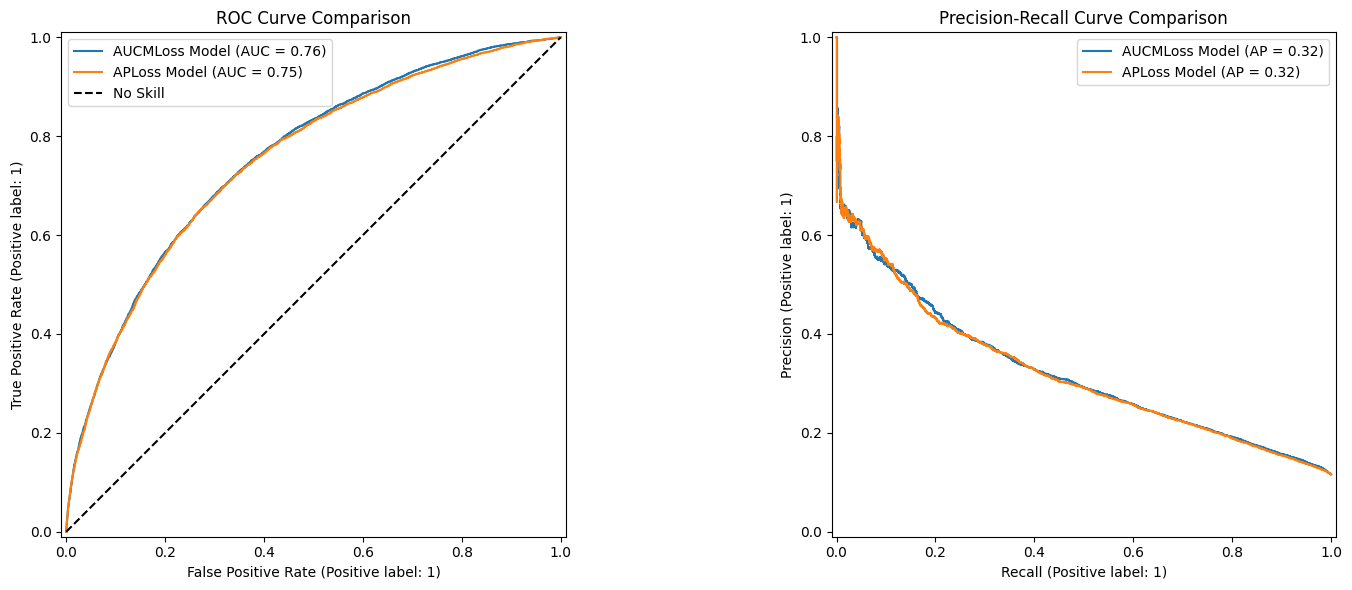

In [ ]:
import torch
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, RocCurveDisplay, PrecisionRecallDisplay
import matplotlib.pyplot as plt
import numpy as np

# This code assumes:
# - model_aucm: trained AUCMLoss model with best weights loaded
# - model_ap: trained APLoss model with best weights loaded
# - X_test_tensor, y_test_tensor: untouched data tensors


# --- 1. SET MODELS TO EVALUATION MODE ---

model_aucm.eval()
model_ap.eval()

# --- 2. GET PREDICTIONS ON THE TEST SET ---


print("Getting predictions on the unseen test set...")
with torch.no_grad():
    # Move the entire test set to the GPU once
    X_test_device = X_test_tensor.to(device)

    # Get raw score predictions from both models
    y_pred_aucm = model_aucm(X_test_device)
    y_pred_ap = model_ap(X_test_device)

    # Move predictions and true labels back to the CPU for scikit-learn
    y_pred_aucm_cpu = y_pred_aucm.cpu().numpy()
    y_pred_ap_cpu = y_pred_ap.cpu().numpy()
    y_test_cpu = y_test_tensor.cpu().numpy()

print("Predictions complete.")

# --- 3. CALCULATE AND PRINT METRICS ---

print("\n" + "="*50)
print("      FINAL MODEL EVALUATION ON TEST SET")
print("="*50 + "\n")

# --- Metrics for the AUCMLoss Model ---
print("--- Results for AUCMLoss Champion Model ---")
auroc_aucm = roc_auc_score(y_test_cpu, y_pred_aucm_cpu)
auprc_aucm = average_precision_score(y_test_cpu, y_pred_aucm_cpu)
print(f"Test AUROC: {auroc_aucm:.4f}")
print(f"Test AUPRC: {auprc_aucm:.4f}")
print("\nClassification Report (threshold = 0.5):")

# standard threshold is 0.5, does not affect AUC
y_pred_class_aucm = (y_pred_aucm_cpu > 0.5).astype(int)
print(classification_report(y_test_cpu, y_pred_class_aucm))

# --- Metrics for the APLoss Model ---
print("\n--- Results for APLoss Challenger Model ---")
auroc_ap = roc_auc_score(y_test_cpu, y_pred_ap_cpu)
auprc_ap = average_precision_score(y_test_cpu, y_pred_ap_cpu)
print(f"Test AUROC: {auroc_ap:.4f}")
print(f"Test AUPRC: {auprc_ap:.4f}")
print("\nClassification Report (threshold = 0.5):")
y_pred_class_ap = (y_pred_ap_cpu > 0.5).astype(int)
print(classification_report(y_test_cpu, y_pred_class_ap))

print("="*50)


# --- 4. VISUALIZE THE RESULTS ---
print("\nGenerating comparison plots...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))


# Flatten the arrays from shape (n, 1) to (n,) before plotting.
y_test_flat = y_test_cpu.ravel()
y_pred_aucm_flat = y_pred_aucm_cpu.ravel()
y_pred_ap_flat = y_pred_ap_cpu.ravel()
# ----------------------

# Plot ROC Curves
RocCurveDisplay.from_predictions(y_test_flat, y_pred_aucm_flat, name="AUCMLoss Model", ax=ax1)
RocCurveDisplay.from_predictions(y_test_flat, y_pred_ap_flat, name="APLoss Model", ax=ax1)
ax1.set_title("ROC Curve Comparison")
ax1.plot([0, 1], [0, 1], 'k--', label='No Skill')
ax1.legend()


# Plot Precision-Recall Curves
PrecisionRecallDisplay.from_predictions(y_test_flat, y_pred_aucm_flat, name="AUCMLoss Model", ax=ax2)
PrecisionRecallDisplay.from_predictions(y_test_flat, y_pred_ap_flat, name="APLoss Model", ax=ax2)
ax2.set_title("Precision-Recall Curve Comparison")
ax2.legend()

plt.tight_layout()
plt.show()
